# Calculate the nonstationary internal tide GP/spectral parameters



In [2]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

# from functools import partial
from jax import numpy as np
# import jax 
import optax
import nonstat_itides_jax as nsjax

In [3]:
import jax
jax.__version__

'0.4.17'

In [4]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [10]:
s3.ls('/uwaoceanprocesses-suntans/')

['uwaoceanprocesses-suntans/.zattrs',
 'uwaoceanprocesses-suntans/.zgroup',
 'uwaoceanprocesses-suntans/.zmetadata',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_eta_seasonaltides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_astrotides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_seasonaltides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_filtered_spacechunk.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_astrotides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_seasonal.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric_filtered_seasonaltides.zarr',
 'uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014

In [44]:
# invarname = 'eta'
# invarname = 'vc'
# invarname = 'uc'

# zarrin = 'NWS_2km_GLORYS_2013_2014_{}_seasonaltides.zarr'.format(invarname)
# varname = '{}_non_phase_locked'.format(invarname)
# dropvars=['{}_non_phase_locked'.format(invarname),'{}_phase_locked'.format(invarname)]

zarrin = 'NWS_2km_GLORYS_2013_2014_surface.zarr'
varname = 'eta'



In [45]:
f = S3Map("uwaoceanprocesses-suntans/"+zarrin, s3=s3)

ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, Nk: 80, time: 8772, Np: 454016)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r      (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells    (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz       (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    eta      (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    nfaces   (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    temp     (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    uc       (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    vc       (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    xp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [46]:
import numpy as onp

def extract_point(xpt, ypt):
    dist = onp.abs( (ds.xv.values-xpt) + 1j*(ds.yv.values-ypt))
    idx = onp.argwhere(dist==dist.min())[0,0]

    return ds.isel(Nc=idx).drop_vars(['xp','yp','cells'])


In [47]:
t1,t2 = '2013-07-15','2014-07-01'
# t1,t2 = '2014-01-02','2014-01-30'
myds = xr.concat([
             extract_point(114.2,-20.5), # Lower NWS (high submesoscale)?
             extract_point(115.6,-9.1), # Lombok
             extract_point(122.8,-12.7),
             extract_point(123.1,-12.9),
             extract_point(114.6,-11.7),
             extract_point(112.1,-11.0), # South Indo
             extract_point( 120.592, -11.567),
             extract_point( 119.609, -13.042),
             extract_point( 112.619, -13.996),
             extract_point( 115, -10.),
             extract_point( 123.1391, -13.9329),
             extract_point( 122.8290, -13.9881),
             extract_point( 123.0319, -14.2290),
                 ], dim='Nc').sel(time=slice(t1,t2))
myds

<xarray.Dataset>
Dimensions:  (Nc: 13, Nk: 80, time: 8436)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-15 2013-07-15T01:00:00 ... 2014-07-01
    z_r      (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, Nk
Data variables:
    dv       (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dz       (Nc, Nk) float64 dask.array<chunksize=(1, 80), meta=np.ndarray>
    eta      (Nc, time) float64 dask.array<chunksize=(1, 409), meta=np.ndarray>
    nfaces   (Nc) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    temp     (Nc, time) float64 dask.array<chunksize=(1, 409), meta=np.ndarray>
    uc       (Nc, time) float64 dask.array<chunksize=(1, 409), meta=np.ndarray>
    vc       (Nc, time) float64 dask.array<chunksize=(1, 409), meta=np.ndarray>
    xv       (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [48]:
from nwatides.hanalysis import least_square

In [49]:
idx = 5
t = myds.time
yraw = myds[varname].isel(Nc=idx)

ymu = yraw.mean()

# Calculate the coherent component
constituents = ['m2','s2','n2','k2','k1','o1','p1','q1']
# constituents = ['m2','s2']
ha = least_square(yraw-ymu, t, constituents)

ycoh = ha['h_predicted']

y = yraw - ymu- ycoh
#y -= y.mean()

tdays = (t-t[0]).values.astype(float)/1e9/86400
X = tdays#[:,None]
dt = X[1]-X[0]

# f_cor = 4*onp.pi/86400*onp.sin(-myds['yv'].isel(Nc=idx).values*onp.pi/180)
# f_cor_cpd =2*onp.pi/f_cor/86400
# f_cor_cpd


In [50]:
####
# eta1 = 0.01
# eta2 = 0.005
# eta3 = 0.01
# dt1 = 5.
# dt2 = 2.0
# dt3 = 2.

# eta_m = 0.1
# l_m = 0.1
# gam_m = 0.5
# covfunc=nsjax.itide_fD2D1_meso_gammaexp
# covparams = (eta_m, l_m, gam_m, eta1, dt1, eta2, dt2, eta3, dt3,)
# cov_kwargs={'f_cor':f_cor_cpd}

covfunc = nsjax.itide_M2S2_meso_gammaexp
eta_m = 0.1
l_m = 20.
gam_m = 1.5
etaM2 = 0.01
etaS2 = 0.01
tauM2 = 5.
tauS2 = 5.
gammaM2 = 1.5
gammaS2 = 1.5
covparams = (eta_m, l_m, gam_m, etaM2, etaS2, tauM2, tauS2, gammaM2, gammaS2)
cov_kwargs={}

# Used for plotting
fmin = 1e-4 #0.7
fmax = 2.5 #

fmins = [1e-4, 1.5]
fmaxs = [0.2, 2.5]

# covfunc=nsjax.itide_meso_nof_gammaexp
# covparams = (eta_m, l_m, gam_m, eta1, dt1, eta2, dt2, )
# paramnames = ['η1','ℓ1', 'η2','ℓ2','η3','ℓ3']



In [51]:
# acf = covfunc(X, X[0], covparams, **cov_kwargs)

# plt.figure()
# plt.plot(X-X[0], acf)

Text(0.5, 0, 'f [cpd]')

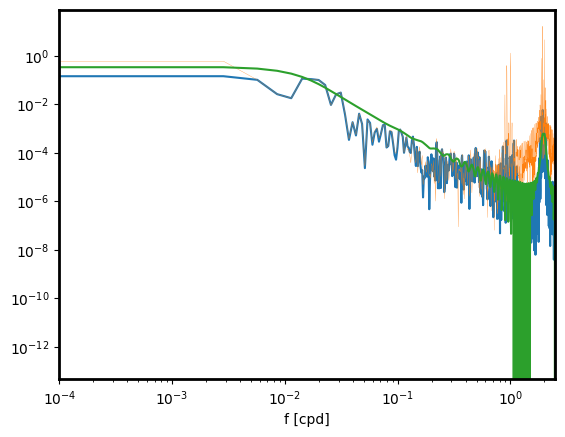

In [68]:
from scipy.signal.windows import hann
acf = covfunc(X, X[0], covparams, **cov_kwargs)

window=hann(X.shape[0]) 

f, Iraw = nsjax.periodogram(yraw.values, dt, h=window)
f, I = nsjax.periodogram(y.values, dt, h=window)
f_S, S = nsjax.bochner(acf, delta=dt)
plt.figure()
# plt.semilogy(f, I)
# plt.semilogy(f_S,S)
plt.loglog(f, I)
plt.loglog(f, Iraw, lw=0.2)

plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

Text(0.5, 0, 'f [cpd]')

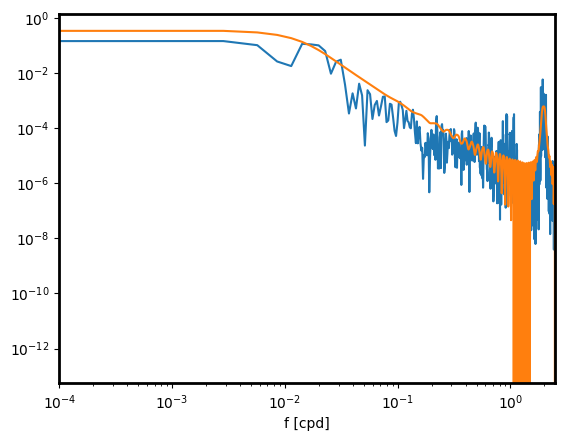

In [69]:
acf = covfunc(X, X[0], covparams, **cov_kwargs)
f, I = nsjax.periodogram(y.values, dt, h=window)
f_S, S = nsjax.bochner(acf, delta=dt)
plt.figure()
# plt.semilogy(f, I)
# plt.semilogy(f_S,S)
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

In [70]:
fidx = ((f > fmins[0]) & (f<fmaxs[0])) | ((f > fmins[1]) & (f<fmaxs[1]))
fidx

Array([False, False, False, ..., False, False, False], dtype=bool)

In [103]:
def logit(x, lower_bound, upper_bound):

    return lower_bound + (upper_bound - lower_bound) / (1 + np.exp(-x))

def invlogit(y, lower_bound, upper_bound):
    return np.log((y - lower_bound) / (upper_bound - y))
    
class CustomTransformer:
    def __init__(self,params):
        self.params = params

    def __call__(self):
        params_t = np.log(self.params)
        params_t = params_t.at[2].set(invlogit(self.params[7],1,2))
        params_t = params_t.at[5].set(invlogit(self.params[8],1,2))
        return params_t
        
    def out(self, tparams):
        params = np.exp(tparams)
        #params[2] = nsjax.logit(tparams[2],scale=2)
        #params[5] = nsjax.logit(tparams[5],scale=2)
        params = params.at[2].set(logit(tparams[7],1,2))
        params = params.at[5].set(logit(tparams[8],1,2))
        #print(params)
        return params
        

In [104]:
invlogit(logit(2.5,1,2), 1,2)

Array(2.5, dtype=float64, weak_type=True)

In [106]:
%%time
params, loss_val = nsjax.estimate_jax(y.values, X, covfunc, covparams, None, None,
                    fidx = fidx,
                      cov_kwargs=cov_kwargs,
                      maxiter=500,
                     opt= optax.adabelief(learning_rate=1e-1),
                     #opt= optax.sgd(learning_rate=3e-4),
                    #transformer=CustomTransformer,                                      
                     verbose=True)
params

step 0, loss: nan
[9.04837418e-02 2.21034184e+01 1.35725613e+00 1.10517092e-02
 1.10517092e-02 4.52418709e+00 4.52418709e+00 1.35725613e+00
 1.35725613e+00]
step 25, loss: -7905.783805634056
[5.65517824e-02 4.92334850e+01 9.99455578e-01 9.40461148e-03
 7.47260921e-03 8.30704377e+00 4.91742613e+00 1.17988810e+00
 1.10721495e+00]
step 50, loss: -8156.895023913921
[5.70953265e-02 3.34728153e+01 1.22668267e+00 1.36590798e-02
 6.11885795e-03 6.12595844e+00 5.70757151e+00 1.70840108e+00
 1.43602676e+00]
step 75, loss: -8226.17662362241
[5.17450383e-02 2.32578885e+01 1.15242594e+00 1.67899766e-02
 7.71650227e-03 4.57564036e+00 4.58040618e+00 2.04227398e+00
 1.55913136e+00]
step 100, loss: -8234.88118660455
[4.82329069e-02 2.04020561e+01 1.12433476e+00 1.45823939e-02
 7.55051935e-03 4.48488590e+00 4.92573272e+00 2.01763840e+00
 1.60414540e+00]
step 102, loss: -8234.749066490576
CPU times: user 1.35 s, sys: 23.8 ms, total: 1.38 s
Wall time: 1.83 s


Array([4.81102026e-02, 2.01177501e+01, 1.12311372e+00, 1.45999951e-02,
       7.55420920e-03, 4.46165744e+00, 4.93929034e+00, 2.01615113e+00,
       1.60657344e+00], dtype=float64)

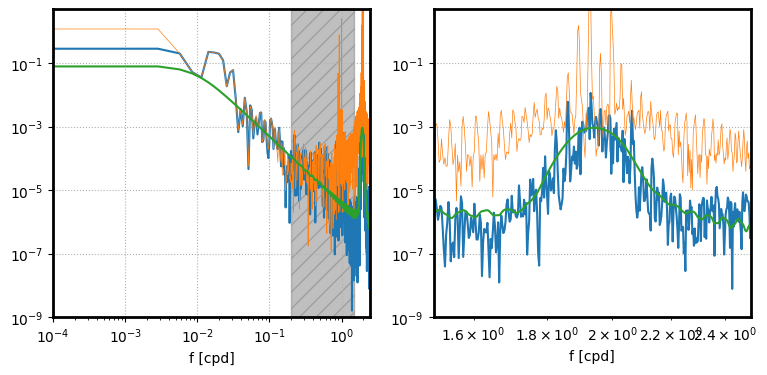

In [107]:
acf = covfunc(X, X[0], params, **cov_kwargs)
f_S, S = nsjax.bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams,**cov_kwargs)
f_S, Si = nsjax.bochner(acf, delta=dt)

plt.figure(figsize=(9,4))
ax=plt.subplot(121)
plt.loglog(f, 2*I)
plt.loglog(f, 2*Iraw, lw=0.5)

plt.loglog(f_S,S)
# plt.loglog(f_S,Si,':')
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')
plt.grid(True, ls=':')
plt.fill_between(f, 1e-9, 5, where=~fidx,
                color='0.5', alpha=0.5, hatch=r"//" )
ax.set_ylim(1e-9, 5)

ax=plt.subplot(122)
plt.semilogy(f, 2*I)
plt.loglog(f, 2*Iraw, lw=0.5)

plt.semilogy(f_S,S)
# plt.semilogy(f_S,Si,':')

plt.xlim(1.5, fmax)
plt.xlabel('f [cpd]')
ax.set_ylim(1e-9, 5)
plt.grid(True, ls=':')

# Try dask

In [73]:
from dask.diagnostics import ProgressBar

In [74]:
# myds2=ds.isel(Nc=slice(1000,1010)).sel(time=slice(t1,t2))
# myds2

In [75]:
import jax.numpy as np

In [76]:
def compute_f_cpd_inv(lat):
    f_cor = 4*np.pi/86400*np.sin(np.abs(lat)*np.pi/180)
    return 2*np.pi/f_cor/86400

In [108]:
%%time
window=None
# inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=None, fmax=fmax)
inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=None, fmax=None, fidx=fidx)

def estimate_spectral_params_jax(yraw, lat, X=X, 
                covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax, fidx=fidx):
    #print(lat)
    
    #f_cor_cpd = compute_f_cpd_inv(lat)

    ###
    # Remove the mean and the harmonics
    ymu = yraw.mean()
    #y = yraw - ymu
    # Calculate the coherent component
    constituents = ['m2','s2','n2','k2','k1','o1','p1','q1']
    # constituents = ['m2','s2']
    ha = least_square(yraw-ymu, t, constituents)
    ycoh = ha['h_predicted'].values
    y = yraw - ymu- ycoh
    ###
    #y = yraw
    
    params, loss_val = nsjax.estimate_jax(y, X, covfunc, covparams, fmin, fmax,
                         fidx = fidx,
                         cov_kwargs=cov_kwargs,
                         maxiter=500,
                         opt= optax.adabelief(learning_rate=1e-1),
                         verbose=False)

    return params, np.array([loss_val])
    #return params, np.array([f_cor_cpd])
    #return np.concatenate([params, np.array([f_cor_cpd]) ])

print('\tBuilding the dask graph...')
params, loss_val = xr.apply_ufunc(estimate_spectral_params_jax,
                      myds[varname].chunk({'time':-1}),
                      myds['yv'],
                      dask='parallelized',
                      kwargs=inputs,
                      output_dtypes=[y.dtype, y.dtype],
                      input_core_dims=(['time',],[]),
                      output_core_dims=(['params'],[]),
                      #output_sizes=,
                      dask_gufunc_kwargs={'output_sizes':{'params':len(covparams)}},
                      vectorize=True,
                     )

with ProgressBar():
    params = params.compute()
    #loss_val = loss_val.compute()
params

	Building the dask graph...
[########################################] | 100% Completed | 23.88 ss
CPU times: user 32.2 s, sys: 10.5 s, total: 42.7 s
Wall time: 23.9 s


<xarray.DataArray (Nc: 13, params: 9)>
array([[5.21369492e-02, 4.07857789e+01, 1.11114091e+00, 1.06492832e-02,
        7.91872468e-03, 3.79939147e+00, 4.11883029e+00, 2.06601494e+00,
        1.83775083e+00],
       [6.36974102e-02, 1.40850281e+01, 1.19907017e+00, 1.33597370e-02,
        6.81951551e-03, 5.78146085e+00, 4.65806226e+00, 1.27797467e+00,
        1.00826242e+00],
       [3.63939811e-02, 9.15481052e+01, 9.85995923e-01, 8.78277260e-03,
        5.32211585e-03, 5.47041368e+00, 5.40105603e+00, 2.01219927e+00,
        1.14396646e+00],
       [4.73962040e-02, 1.81121890e+02, 8.72424725e-01, 4.84590725e-03,
        5.37905503e-03, 4.47218611e+00, 4.62372557e+00, 2.10339654e+00,
        1.80645365e+00],
       [5.02073163e-02, 8.31152484e+00, 1.77771281e+00, 1.49031111e-02,
        5.52631292e-03, 4.07434184e+00, 3.68814260e+00, 2.10141164e+00,
        9.53769625e-01],
       [4.81102026e-02, 2.01177501e+01, 1.12311372e+00, 1.45999951e-02,
        7.55420920e-03, 4.46165744e+00, 4.93929034e+00, 2.01615113e+00,
        1.60657344e+00],
       [3.12777490e-02, 7.06657170e+00, 1.52051005e+00, 7.49735865e-03,
        3.06085235e-03, 3.84625842e+00, 2.91508167e+00, 2.11564475e+00,
        8.94188263e-01],
       [5.44019615e-02, 6.65330778e+01, 9.82030176e-01, 1.59234504e-02,
        4.52761643e-03, 4.98210137e+00, 4.80511615e+00, 2.04079311e+00,
        1.30093298e+00],
       [5.80282346e-02, 8.42017151e+01, 9.25728512e-01, 1.36328733e-02,
        7.87829416e-03, 4.51626458e+00, 4.35938673e+00, 1.97138974e+00,
        2.01827980e+00],
       [4.96086708e-02, 9.35907173e+00, 1.73006158e+00, 1.13663830e-02,
        6.85276720e-03, 3.81301810e+00, 3.93970368e+00, 2.11953613e+00,
        1.18441784e+00],
       [4.64477645e-02, 8.32497433e+01, 9.19223890e-01, 9.99579874e-03,
        1.04897989e-02, 4.13146326e+00, 4.20598995e+00, 2.07424665e+00,
        1.82271546e+00],
       [4.24617642e-02, 5.47223574e+01, 9.72725301e-01, 7.05387091e-03,
        7.91731999e-03, 4.43428079e+00, 4.16279165e+00, 2.10946221e+00,
        1.80907270e+00],
       [4.46984589e-02, 5.08892290e+01, 9.54846077e-01, 8.13155872e-03,
        9.90971287e-03, 4.03537838e+00, 3.94869081e+00, 2.11366682e+00,
        1.83528473e+00]])
Dimensions without coordinates: Nc, params

In [20]:
# Plot all the sites...

In [109]:
def plot_site(myds, params, ii):
    yraw = myds[varname].isel(Nc=ii)
    # Remove the mean and the harmonics
    ymu = yraw.mean()
    #y = yraw - ymu
    # Calculate the coherent component
    constituents = ['m2','s2','n2','k2','k1','o1','p1','q1']
    # constituents = ['m2','s2']
    ha = least_square(yraw-ymu, t, constituents)
    ycoh = ha['h_predicted'].values
    y = yraw - ymu- ycoh

    #y -= y.mean()
    
    X = (myds.time-myds.time[0]).values.astype(float)/1e9/86400
    X = tdays#[:,None]
    dt = X[1]-X[0]
    f, I = nsjax.periodogram(y.values, dt)
    acf = covfunc(X, X[0], params[ii,:].values, **cov_kwargs)
    f_S, S = nsjax.bochner(acf, delta=dt)
    
    plt.figure(figsize=(9,4))
    ax1=plt.subplot(121)
    plt.loglog(f, 2*I)
    plt.loglog(f_S,S)
    # plt.loglog(f_S,Si,':')
    plt.xlim(fmin, fmax)
    plt.xlabel('f [cpd]')
    plt.grid(True, ls=':')
    plt.ylim(1e-7,1e1)
    plt.fill_between(f, 1e-7, 10, where=~fidx,
                color='0.5', alpha=0.5, hatch=r"//" )
    
    ax2=plt.subplot(122)
    plt.semilogy(f, 2*I)
    plt.semilogy(f_S,S)
    # plt.semilogy(f_S,Si,':')
    
    plt.xlim(1.5, fmax)
    plt.xlabel('f [cpd]')
    ax1.set_title('lon: {:3.2f} E, lat: {:3.2f} N'.format(myds.xv[ii].values, myds.yv.values[ii]))
    plt.grid(True, ls=':')
    plt.ylim(1e-7,1e1)
    ax1.text(0.02,1.02, '(a)', transform=ax1.transAxes)
    ax2.text(0.02,1.02, '(b)', transform=ax2.transAxes)

    plt.tight_layout()

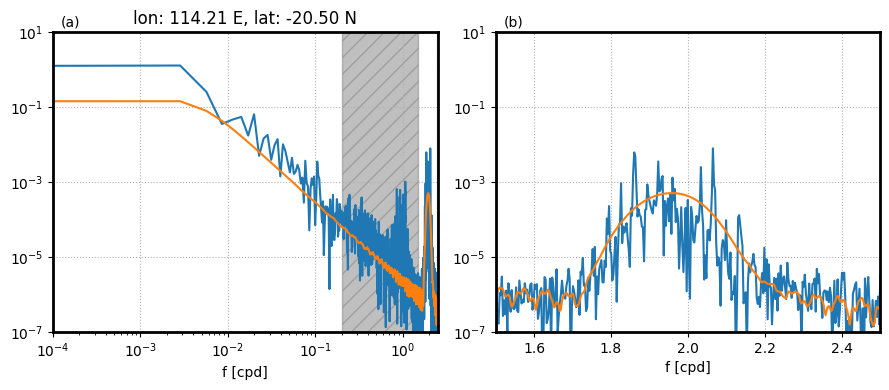

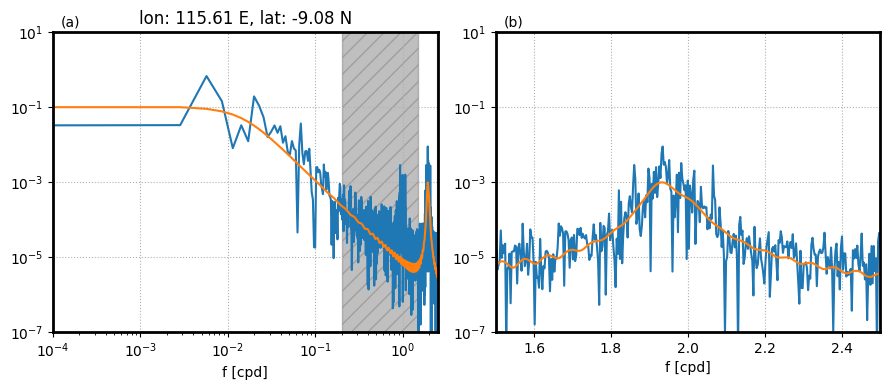

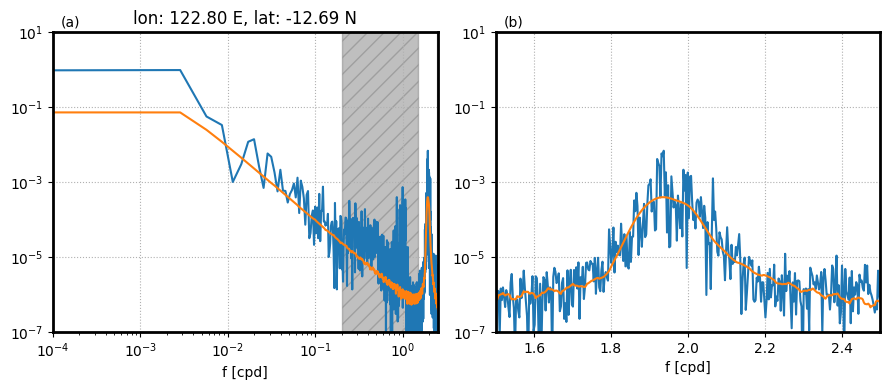

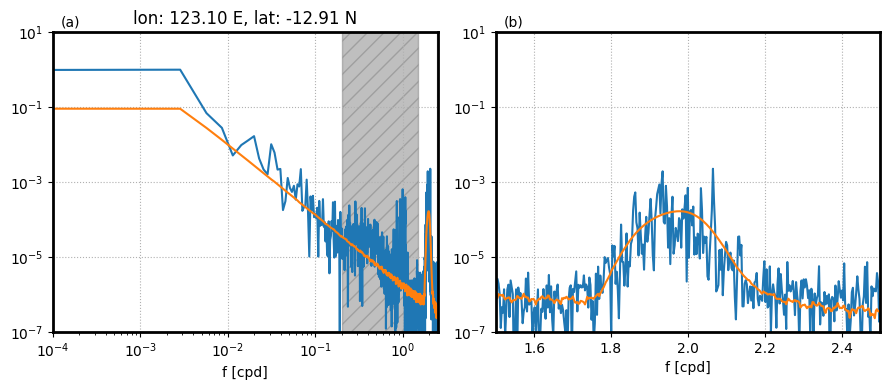

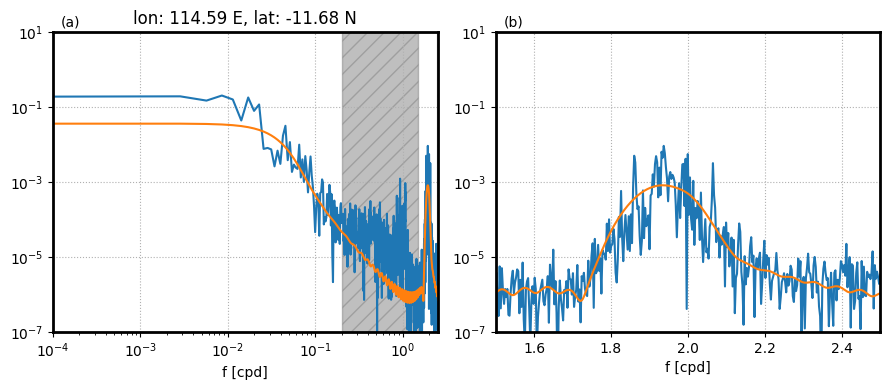

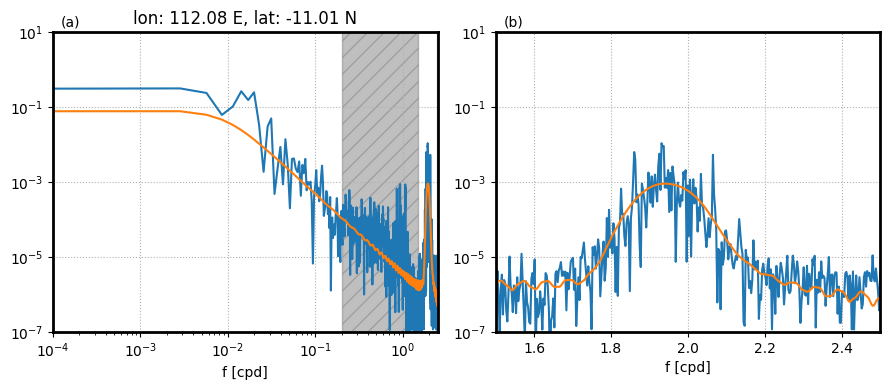

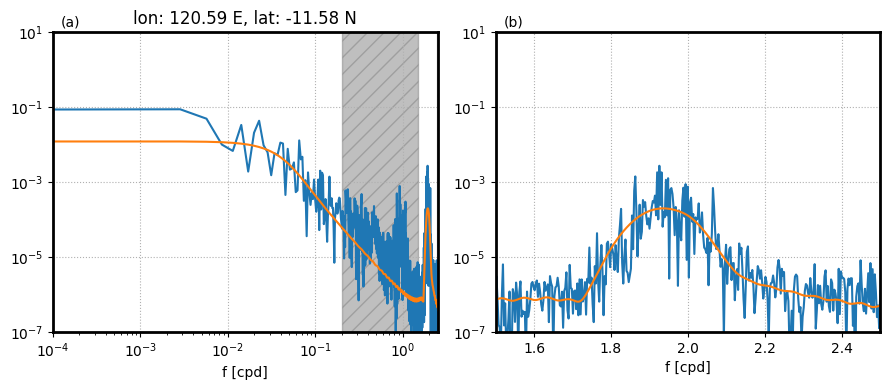

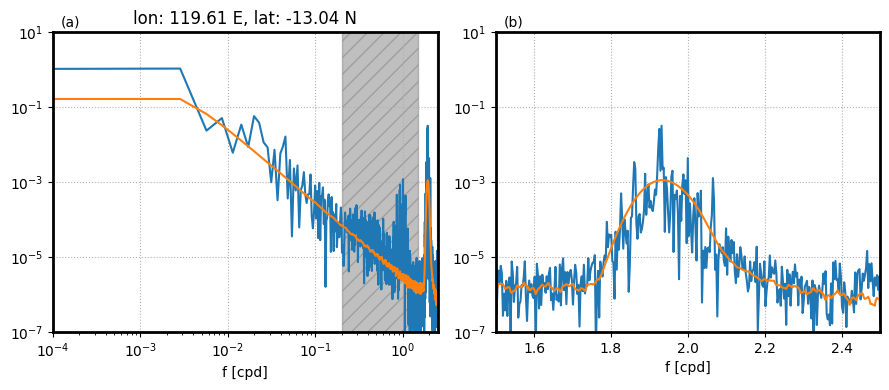

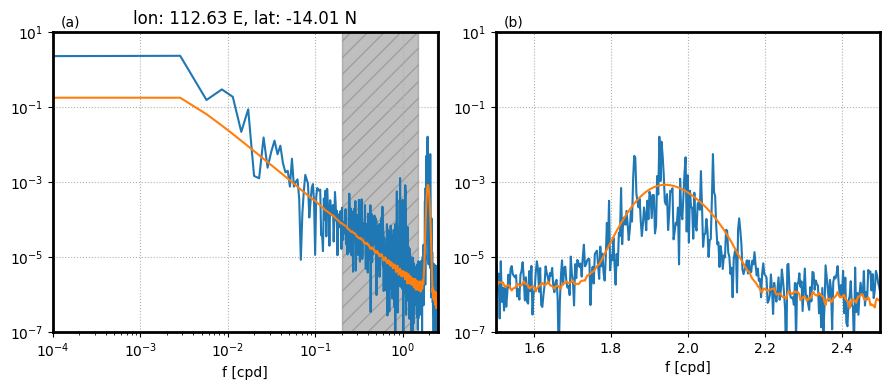

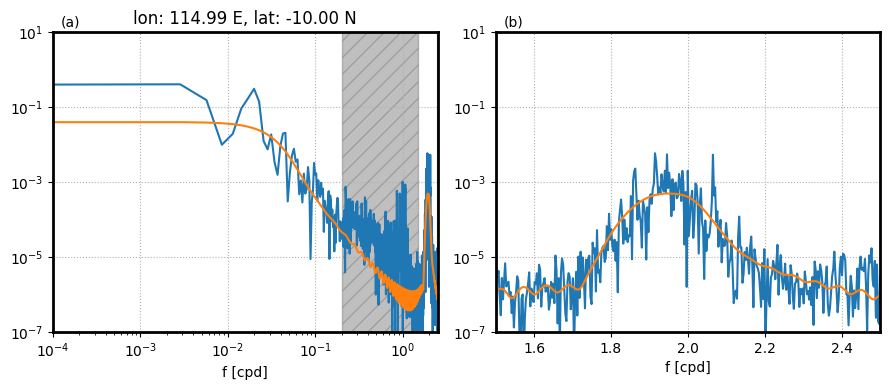

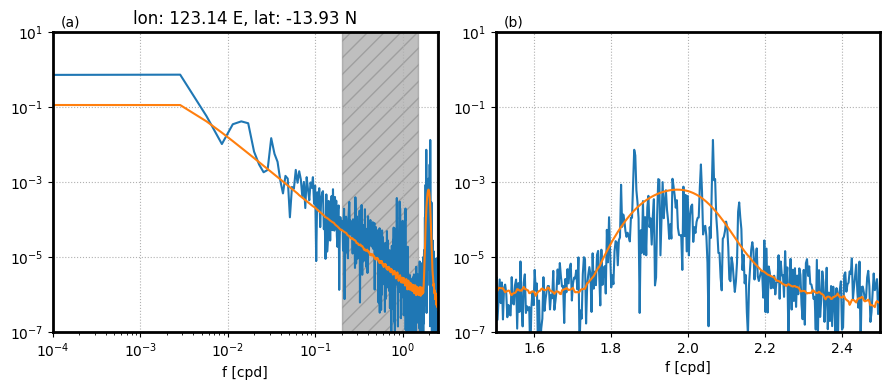

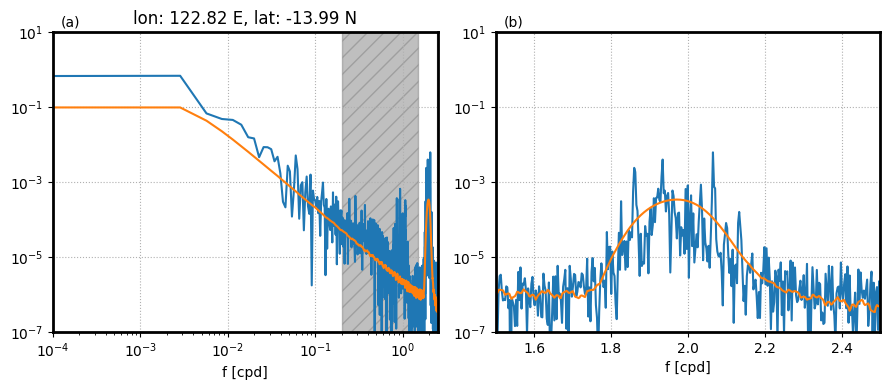

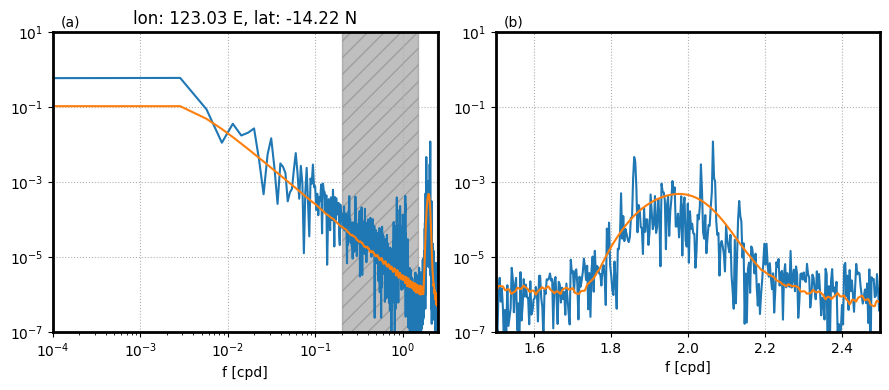

In [110]:
for ii in range(13):
    plot_site(myds, params, ii)
    #plt.savefig('../FIGURES/SUNTANS_PSD_v_eg_{:03d}.png'.format(ii), dpi=150)
    plt.savefig('../FIGURES/SUNTANS_PSD_M2S2_{}_eg_{:03d}.png'.format(varname,ii), dpi=150)

# Testing below here...

In [222]:
# This is hard-wired to the case above
def dwhittle_fast(x, y, ff, I, acffunc, params, delta = 1, h = None, fmin=0, fmax=np.inf):

    ff_boch, S_boch = bochner(acffunc(x, x[0], params), delta = delta, bias = True)

    # Subset frequencies
    #idx_boch = (ff_boch > fmin) & (ff_boch<fmax)
    idx = (ff > fmin) & (ff<fmax)

    # HACK: quick fix cause bochner isn't two sided yet
    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()
    #return - 2 * np.sum(np.log(S_boch[idx]) + I[idx]/S_boch[idx])

@jax.value_and_grad
@partial(jax.jit, static_argnums=(5,6,7,8))
def loss(logparams,  X, y, f, I, covfunc,  dt, fmin, fmax):
    params = np.exp(logparams)
    return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax) 
    

In [223]:
dwhittle_fast(X, y.values, f, I, covfunc, covparams, fmin=fmin, fmax=fmax)

Array(94.04004, dtype=float32)

In [226]:
x=X
idx = (f > fmin) & (f<fmax)
def dwhittle_jax(params, acffunc):

    ff_boch, S_boch = bochner(acffunc(x, x[0], params))

    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()

@jax.value_and_grad
@partial(jax.jit, static_argnums=(1))
def loss2(logparams, covfunc):
    params = np.exp(logparams)
    return -dwhittle_jax(params, covfunc) 

In [227]:
logparams = np.log(np.array(covparams))
# loss(logparams, np.array(X), np.array(y.values), f, I, covfunc,  dt, fmin, fmax)
loss2(logparams, covfunc)

(Array(-94.02051, dtype=float32),
 Array([-10123.3955,   6188.308 ,  -5100.722 ,   4073.4658,  -2464.0906],      dtype=float32))

In [229]:
%%time
opt = optax.sgd(learning_rate=3e-4)
# opt = optax.adam(learning_rate=1e-1)

opt_state = opt.init(logparams)
loss_val = np.inf
for i in range(500):
    #loss_val_new, grads = loss(logparams, np.array(X), np.array(y.values), f, I, covfunc,  dt, fmin, fmax)
    loss_val_new, grads = loss2(logparams, covfunc)
    updates, opt_state = opt.update(grads, opt_state)
    logparams = optax.apply_updates(logparams, updates)
    if i % 10 == 0:
        print(f'step {i}, loss: {loss_val_new}')
        print(np.exp(logparams))
    if np.abs(loss_val_new-loss_val) < 1e-2:
        print(f'step {i}, loss: {loss_val}')
        break

    loss_val = 1*loss_val_new


step 0, loss: -94.0205078125
[3.1264520e-01 1.5621961e+00 4.6191774e-03 2.9462857e+00 2.0943162e-06]
step 10, loss: -8574.44921875
[1.6673638e-02 1.0366410e+01 3.9194878e-03 1.9094799e+00 2.1366334e-06]
step 20, loss: -8687.0068359375
[1.4606985e-02 9.8059378e+00 3.3099456e-03 1.1555848e+00 2.2024378e-06]
step 30, loss: -8717.005859375
[1.3002753e-02 8.9476681e+00 3.2535247e-03 9.1621125e-01 2.2328136e-06]
step 40, loss: -8727.3828125
[1.1769324e-02 8.0455027e+00 3.2717658e-03 8.3886057e-01 2.2491135e-06]
step 50, loss: -8733.923828125
[1.0806603e-02 7.2658005e+00 3.2842890e-03 8.0960006e-01 2.2608058e-06]
step 60, loss: -8738.2978515625
[1.0082160e-02 6.6614285e+00 3.2905014e-03 7.9747480e-01 2.2707673e-06]
step 70, loss: -8740.84765625
[9.5710391e-03 6.2306075e+00 3.2931133e-03 7.9241145e-01 2.2799309e-06]
step 80, loss: -8742.107421875
[9.2338538e-03 5.9446020e+00 3.2938782e-03 7.9052067e-01 2.2886709e-06]
step 90, loss: -8742.646484375
[9.0235481e-03 5.7651720e+00 3.2938216e-03 7.9

Text(0.5, 0, 'f [cpd]')

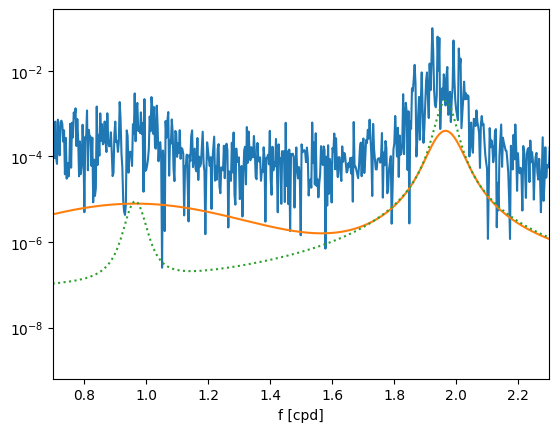

In [230]:
acf = covfunc(X, X[0], np.exp(logparams))
f_S, S = bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams)
f_S, Si = bochner(acf, delta=dt)

plt.figure()
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.semilogy(f_S,Si,':')

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

step 0, loss: 253890.65625
[1.0177167e+35 2.0136395e-22 8.2618419e+13 5.2516368e-13 9.8452469e+01]
step 10, loss: nan
[nan nan nan nan nan]
step 20, loss: nan
[nan nan nan nan nan]
step 30, loss: nan
[nan nan nan nan nan]
step 40, loss: nan
[nan nan nan nan nan]
step 50, loss: nan
[nan nan nan nan nan]
step 60, loss: nan
[nan nan nan nan nan]
step 70, loss: nan
[nan nan nan nan nan]
step 80, loss: nan
[nan nan nan nan nan]
step 90, loss: nan
[nan nan nan nan nan]
step 100, loss: nan
[nan nan nan nan nan]
step 110, loss: nan
[nan nan nan nan nan]
step 120, loss: nan
[nan nan nan nan nan]
step 130, loss: nan
[nan nan nan nan nan]
step 140, loss: nan
[nan nan nan nan nan]
step 150, loss: nan
[nan nan nan nan nan]
step 160, loss: nan
[nan nan nan nan nan]
step 170, loss: nan
[nan nan nan nan nan]
step 180, loss: nan
[nan nan nan nan nan]
step 190, loss: nan
[nan nan nan nan nan]
step 200, loss: nan
[nan nan nan nan nan]
step 210, loss: nan
[nan nan nan nan nan]
step 220, loss: nan
[nan nan

Array([nan, nan, nan, nan, nan], dtype=float32)

Text(0.5, 0, 'f [cpd]')

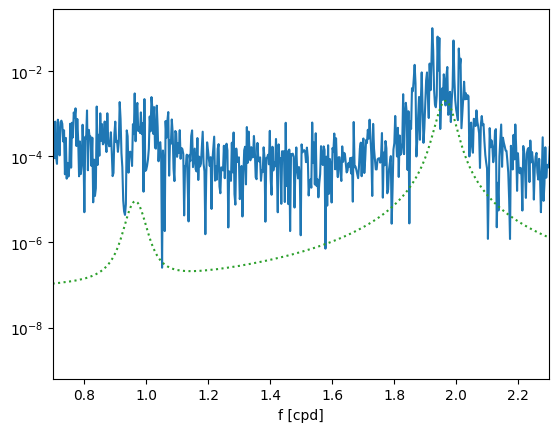

In [233]:
acf = covfunc(X, X[0], params)
f_S, S = bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams)
f_S, Si = bochner(acf, delta=dt)

plt.figure()
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.semilogy(f_S,Si,':')

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')